In [2]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [3]:
dataset_path = '/Users/hongtan/Downloads/archive/audio_speech_actors_01-24'

In [4]:
# Function to extract features from each audio file
def extract_features(file_path):
    audio, sampling_rate = librosa.load(file_path, sr=22050, duration=None)
#     mfccs = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=30)
#     features = np.mean(mfccs.T, axis=0)
#     features=np.mean(librosa.feature.melspectrogram(y=audio, sr=sampling_rate).T,axis=0)
    
    features=np.array([])
    
    stft=np.abs(librosa.stft(audio))
    
    mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=30).T, axis=0)

    chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sampling_rate).T,axis=0)

    mel=np.mean(librosa.feature.melspectrogram(y=audio, sr=sampling_rate).T,axis=0)
    
    features=np.hstack((mfccs, chroma, mel))
    
    return features

# Function to preprocess the data
def preprocess_data(dataset_path):
    X = []
    y = []
    for folder in os.listdir(dataset_path):
        for file in os.listdir(os.path.join(dataset_path, folder)):
            if file.endswith('.wav'):
                
                emotion = file.split('-')[2]
                if int(emotion) == 1:
                    label = 'Neutral'
                elif int(emotion) == 2:
                    label = 'Calm'
                elif int(emotion) == 3:
                    label = 'Happy'
                elif int(emotion) == 4:
                    label = 'Sad'
                elif int(emotion) == 5:
                    label = 'Angry'
                elif int(emotion) == 6:
                    label = 'Fearful'
                elif int(emotion) == 7:
                    label = 'Disgust'
                elif int(emotion) == 8:
                    label = 'Surprised'
                else:
                    label = 'UNK'
                    
                file_path = os.path.join(dataset_path, folder, file)
                features = extract_features(file_path)
                X.append(features)
                y.append(label)
    return np.array(X), np.array(y)

In [5]:
# Preprocess the data
X, y = preprocess_data(dataset_path)

# Print the shape of the feature matrix and the label array
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 170)
Shape of y: (1440,)


In [6]:
# One-Hot encode y
OHE = OneHotEncoder()

y = np.array(y).reshape(-1,1)
y = OHE.fit_transform(y).toarray()

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29, test_size=0.20, shuffle=True)

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1152, 170)
y_train: (1152, 8)
X_test: (288, 170)
y_test: (288, 8)


In [8]:
# Normalize data
SS = StandardScaler()

X_train = SS.fit_transform(X_train)
X_test = SS.transform(X_test)

print('X_train: {}'.format(X_train.shape))
print('y_train: {}'.format(y_train.shape))
print('X_test: {}'.format(X_test.shape))
print('y_test: {}'.format(y_test.shape))

X_train: (1152, 170)
y_train: (1152, 8)
X_test: (288, 170)
y_test: (288, 8)


In [9]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print('X_train: {}'.format(X_train.shape))
print('X_test: {}'.format(X_test.shape))

X_train: (1152, 170, 1)
X_test: (288, 170, 1)


In [16]:
# from keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Function to plot Training Accuracy vs Validation Accuracy
def TrainVal_plot(history):
    val_acc = history.history['val_accuracy']
    train_acc = history.history['accuracy']

    epochs = range(0, 300)
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.title('Training vs. Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [11]:
# Import necessary libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define input shape
input_shape = (X_train.shape[1], 1)

# Create model
model = Sequential()

model.add(Conv1D(filters=8, kernel_size=3, activation='relu', input_shape=input_shape ,use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(filters=16, kernel_size=3, activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Conv1D(filters=32, kernel_size=3, activation='relu', use_bias=False))
model.add(BatchNormalization())
model.add(MaxPooling1D())

model.add(Flatten())

model.add(Dense(units=64, activation='relu', use_bias=False))
model.add(BatchNormalization())

model.add(Dropout(0.5))

model.add(Dense(units=8, activation='softmax'))

adam = Adam(learning_rate=0.01)
# Compile model with appropriate loss function, optimizer and metrics
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Print model summary
model.summary()

Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 8)            24        
                                                                 
 batch_normalization (BatchN  (None, 168, 8)           32        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 84, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 82, 16)            384       
                                                                 
 batch_normalization_1 (Batc  (None, 82, 16)           64        
 hNormalization)                                                 
                      

In [12]:
history = model.fit(X_train, y_train, batch_size=4, epochs=300, validation_data=(X_test, y_test),)
# callbacks=[early_stop])

Epoch 1/300


2023-04-16 20:25:47.682667: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


288/288 [==============================] - 5s 13ms/step - loss: 2.1331 - accuracy: 0.2517 - val_loss: 3.6353 - val_accuracy: 0.2188
Epoch 2/300
288/288 [==============================] - 4s 14ms/step - loss: 1.9376 - accuracy: 0.2465 - val_loss: 2.5460 - val_accuracy: 0.2292
Epoch 3/300
288/288 [==============================] - 4s 13ms/step - loss: 1.9050 - accuracy: 0.2760 - val_loss: 1.8995 - val_accuracy: 0.3090
Epoch 4/300
288/288 [==============================] - 4s 13ms/step - loss: 1.8598 - accuracy: 0.2873 - val_loss: 2.4567 - val_accuracy: 0.3299
Epoch 5/300
288/288 [==============================] - 4s 13ms/step - loss: 1.8265 - accuracy: 0.3012 - val_loss: 2.0759 - val_accuracy: 0.2917
Epoch 6/300
288/288 [==============================] - 4s 13ms/step - loss: 1.8032 - accuracy: 0.3142 - val_loss: 2.5339 - val_accuracy: 0.2847
Epoch 7/300
288/288 [==============================] - 4s 13ms/step - loss: 1.7884 - accuracy: 0.3238 - val_loss: 3.2604 - val_accuracy: 0.2188
Epoc

288/288 [==============================] - 4s 14ms/step - loss: 1.4673 - accuracy: 0.4722 - val_loss: 17.6077 - val_accuracy: 0.4306
Epoch 58/300
288/288 [==============================] - 4s 14ms/step - loss: 1.4500 - accuracy: 0.4905 - val_loss: 14.3759 - val_accuracy: 0.3958
Epoch 59/300
288/288 [==============================] - 4s 13ms/step - loss: 1.3784 - accuracy: 0.5182 - val_loss: 13.0735 - val_accuracy: 0.4271
Epoch 60/300
288/288 [==============================] - 4s 13ms/step - loss: 1.4671 - accuracy: 0.4774 - val_loss: 16.2631 - val_accuracy: 0.3750
Epoch 61/300
288/288 [==============================] - 4s 13ms/step - loss: 1.4436 - accuracy: 0.4931 - val_loss: 8.6371 - val_accuracy: 0.4549
Epoch 62/300
288/288 [==============================] - 4s 13ms/step - loss: 1.3888 - accuracy: 0.5148 - val_loss: 14.4472 - val_accuracy: 0.4132
Epoch 63/300
288/288 [==============================] - 4s 13ms/step - loss: 1.3614 - accuracy: 0.5217 - val_loss: 13.3072 - val_accuracy:

288/288 [==============================] - 4s 13ms/step - loss: 1.2075 - accuracy: 0.5955 - val_loss: 19.4994 - val_accuracy: 0.4410
Epoch 114/300
288/288 [==============================] - 4s 13ms/step - loss: 1.1652 - accuracy: 0.5998 - val_loss: 6.3153 - val_accuracy: 0.4444
Epoch 115/300
288/288 [==============================] - 4s 13ms/step - loss: 1.1187 - accuracy: 0.6215 - val_loss: 41.4828 - val_accuracy: 0.4201
Epoch 116/300
288/288 [==============================] - 4s 13ms/step - loss: 1.1596 - accuracy: 0.6137 - val_loss: 11.0008 - val_accuracy: 0.4722
Epoch 117/300
288/288 [==============================] - 4s 13ms/step - loss: 1.1346 - accuracy: 0.6024 - val_loss: 8.9957 - val_accuracy: 0.4306
Epoch 118/300
288/288 [==============================] - 4s 13ms/step - loss: 1.1586 - accuracy: 0.6111 - val_loss: 22.7043 - val_accuracy: 0.4618
Epoch 119/300
288/288 [==============================] - 4s 13ms/step - loss: 1.1401 - accuracy: 0.6068 - val_loss: 25.8153 - val_accu

288/288 [==============================] - 4s 13ms/step - loss: 1.1228 - accuracy: 0.6554 - val_loss: 36.2416 - val_accuracy: 0.4097
Epoch 170/300
288/288 [==============================] - 4s 12ms/step - loss: 1.0440 - accuracy: 0.6415 - val_loss: 54.9712 - val_accuracy: 0.4097
Epoch 171/300
288/288 [==============================] - 4s 13ms/step - loss: 1.0288 - accuracy: 0.6467 - val_loss: 43.0577 - val_accuracy: 0.4931
Epoch 172/300
288/288 [==============================] - 4s 13ms/step - loss: 0.9503 - accuracy: 0.6719 - val_loss: 32.5103 - val_accuracy: 0.4410
Epoch 173/300
288/288 [==============================] - 4s 13ms/step - loss: 0.9219 - accuracy: 0.6797 - val_loss: 22.9471 - val_accuracy: 0.4792
Epoch 174/300
288/288 [==============================] - 4s 13ms/step - loss: 0.9312 - accuracy: 0.6892 - val_loss: 21.1501 - val_accuracy: 0.4514
Epoch 175/300
288/288 [==============================] - 4s 13ms/step - loss: 0.9248 - accuracy: 0.6962 - val_loss: 25.5151 - val_ac

Epoch 225/300
288/288 [==============================] - 4s 13ms/step - loss: 1.0830 - accuracy: 0.6233 - val_loss: 3.9246 - val_accuracy: 0.4965
Epoch 226/300
288/288 [==============================] - 4s 13ms/step - loss: 1.0114 - accuracy: 0.6406 - val_loss: 16.1040 - val_accuracy: 0.4549
Epoch 227/300
288/288 [==============================] - 4s 13ms/step - loss: 1.0094 - accuracy: 0.6623 - val_loss: 14.7665 - val_accuracy: 0.4826
Epoch 228/300
288/288 [==============================] - 4s 13ms/step - loss: 0.9281 - accuracy: 0.6962 - val_loss: 17.8252 - val_accuracy: 0.5035
Epoch 229/300
288/288 [==============================] - 4s 13ms/step - loss: 0.8983 - accuracy: 0.7049 - val_loss: 9.9675 - val_accuracy: 0.5174
Epoch 230/300
288/288 [==============================] - 4s 13ms/step - loss: 0.7903 - accuracy: 0.7396 - val_loss: 9.5029 - val_accuracy: 0.4583
Epoch 231/300
288/288 [==============================] - 4s 13ms/step - loss: 0.7836 - accuracy: 0.7370 - val_loss: 11.70

Epoch 281/300
288/288 [==============================] - 4s 13ms/step - loss: 0.7660 - accuracy: 0.7413 - val_loss: 8.4146 - val_accuracy: 0.4653
Epoch 282/300
288/288 [==============================] - 4s 14ms/step - loss: 0.9374 - accuracy: 0.6962 - val_loss: 4.9071 - val_accuracy: 0.4340
Epoch 283/300
288/288 [==============================] - 4s 13ms/step - loss: 0.8032 - accuracy: 0.7283 - val_loss: 6.9323 - val_accuracy: 0.4653
Epoch 284/300
288/288 [==============================] - 4s 14ms/step - loss: 0.8196 - accuracy: 0.7135 - val_loss: 2.8217 - val_accuracy: 0.3993
Epoch 285/300
288/288 [==============================] - 4s 14ms/step - loss: 0.8066 - accuracy: 0.7292 - val_loss: 3.1788 - val_accuracy: 0.4618
Epoch 286/300
288/288 [==============================] - 4s 14ms/step - loss: 0.7666 - accuracy: 0.7326 - val_loss: 7.2156 - val_accuracy: 0.4583
Epoch 287/300
288/288 [==============================] - 4s 14ms/step - loss: 0.7140 - accuracy: 0.7622 - val_loss: 5.8328 -

In [13]:
print("Accuracy of our model on Train data : " , round(model.evaluate(X_train,y_train)[1]*100,2) , "%")

36/36 [==============================] - 0s 7ms/step - loss: 5.0681 - accuracy: 0.9028
Accuracy of our model on Train data :  90.28 %


In [14]:
print("Accuracy of our model on test data : " , round(model.evaluate(X_test,y_test)[1]*100,2) , "%")

9/9 [==============================] - 0s 8ms/step - loss: 11.3561 - accuracy: 0.5035
Accuracy of our model on test data :  50.35 %


0 --> Angry
1 --> Calm
2 --> Disgust
3 --> Fearful
4 --> Happy
5 --> Neutral
6 --> Sad
7 --> Surprised

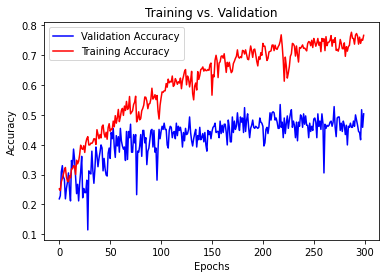

In [17]:
TrainVal_plot(history)

In [18]:
emotions = ['Angry', 'Calm', 'Disgust', 'Fearful', 'Happy', 'Neutral', 'Sad', 'Surprised']

In [19]:
input_file = '/Users/hongtan/Downloads/inside_out_clip.mp4'
output_srt_file = "/Users/hongtan/Desktop/sentimentsub/website/sentsub/media/captions/audio.srt"
output_wav_file = "/Users/hongtan/Downloads/output.wav"
output_folder = "/Users/hongtan/Desktop/segmented-audio/"

insane_input_file = '/Users/hongtan/Desktop/sentimentsub/speech-to-text/audio-test-files/insane.wav'

In [28]:
# Running model on files
audio_file = output_folder + '6.wav'
audio_features = extract_features(audio_file)
audio_features = np.expand_dims(audio_features, axis=1)
audio_features.shape
test = np.array([audio_features])
prediction = model.predict(test)
emotions[np.argmax(prediction)]

1/1 [==============================] - 0s 23ms/step


'Fearful'

In [ ]:
# Get SRT file
import stable_whisper
whisper_model = stable_whisper.load_model('base')
result = whisper_model.transcribe(insane_input_file, fp16=False)
result.to_srt_vtt(output_srt_file, word_level=False)

In [ ]:
# Segment mp4 file into multiple wav files according to SRT file
from pydub import AudioSegment
import os

# Load audio file
# sound = AudioSegment.from_file(input_file, format="mp4")
# sound = sound.set_channels(1)
# sound.export(output_wav_file, format="wav")
audio = AudioSegment.from_wav(insane_input_file)

# Parse SRT file
with open(output_srt_file, "r") as f:
    lines = f.readlines()
    subtitles = []
    for line in lines:
        if "-->" in line:
            start, end = line.strip().split(" --> ")
            start = start.split(":")
            end = end.split(":")
            start = int(start[0]) * 3600 + int(start[1]) * 60 + float(start[2].replace(",", "."))
            end = int(end[0]) * 3600 + int(end[1]) * 60 + float(end[2].replace(",", "."))
            subtitles.append((start * 1000, end * 1000))

# Create output directory
os.makedirs(output_folder, exist_ok=True)

# Split audio file and export segments
for i, (start, end) in enumerate(subtitles):
    segment = audio[start:end]
    segment.export(output_folder + str(i) + ".wav", format="wav")